In [1]:
import os
os.chdir('..')

from comet_ml import Experiment, OfflineExperiment

from typing import Tuple, List
import logging

import numpy as np
import syft as sy
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

from syftutils.datasets import get_dataset_items_at

from SyftFederatedLearner import SyftFederatedLearner, SyftFederatedLearnerConfig


class SyftFederatedLearnerMNISTConfig(SyftFederatedLearnerConfig):
    IS_IID_DATA: bool = True  # If true, the data is split random amongs clients. If false, the client have different digits.


class SyftFederatedLearnerMNIST(SyftFederatedLearner):
    def __init__(
        self, experiment: Experiment, config: SyftFederatedLearnerMNISTConfig
    ) -> None:
        """Initialises the training.

        Arguments:
            experiment {Experiment} -- Comet.ml experiment object for online logging.
            config {SyftFederatedLearnerMNISTConfig} -- Training configuration description.
        """
        super().__init__(experiment, config)
        self.config = config  # Purly to help intellisense

    def load_data(self) -> Tuple[List[th.utils.data.DataLoader], th.utils.data.DataLoader]:
        logging.info("MNIST data loading ...")
        minist_train_ds, mnist_test_ds = self.__get_mnist()
        logging.info("MNIST data loaded.")

        logging.info("Data distributing ...")
        if self.config.IS_IID_DATA:
            federated_train_dataset = minist_train_ds.federate(
                self.clients
            )  # TODO HARD get list of index samples instead
        else:
            indices = self.__distribute_data_non_IID(
                minist_train_ds
            )  # TODO get list of index samples instead

        # TODO HARD use list of DataLoader and indices with sampler
        train_loader_list = []
        for idx in indices:
            sampler = th.utils.data.sampler.SubsetRandomSampler(idx)
            loader = th.utils.data.DataLoader(
                dataset=minist_train_ds,
                batch_size=self.config.BATCH_SIZE,
                num_workers=self.config.DL_N_WORKER,
                sampler=sampler,
            )
            train_loader_list.append(loader)
        # federated_train_loader = sy.FederatedDataLoader(
        #     federated_train_dataset,
        #     batch_size=self.config.BATCH_SIZE,
        #     shuffle=True,
        #     num_workers=self.config.DL_N_WORKER,
        #     pin_memory=True,
        # )
        logging.info("Data distributed.")

        test_loader = th.utils.data.DataLoader(
            mnist_test_ds,
            batch_size=64,
            shuffle=True,
            num_workers=self.config.DL_N_WORKER,
        )

        return train_loader_list, test_loader

    def __get_mnist(self):
        minist_train_ds = datasets.MNIST(
            "../data",
            train=True,
            download=True,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        )
        mnist_test_ds = datasets.MNIST(
            "../data",
            train=False,
            transform=transforms.Compose(
                [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
            ),
        )
        return minist_train_ds, mnist_test_ds

    def __distribute_data_non_IID(self, minist_train_ds):
        digit_sort_idx = np.concatenate(
            [np.where(minist_train_ds.targets == i)[0] for i in range(10)]
        )
        digit_sort_idx = digit_sort_idx.reshape(2 * self.config.N_CLIENTS, -1)
        np.random.shuffle(digit_sort_idx)
        indices = [
            digit_sort_idx[i : i + 2,].flatten()
            for i in range(0, 2 * self.config.N_CLIENTS, 2)
        ]
        return indices
        # TODO return idices and remove the rest
        # dss = []
        # for idx, c in zip(indices, self.clients):
        #     data, target = get_dataset_items_at(minist_train_ds, idx)
        #     dss.append(sy.BaseDataset(data.send(c), target.send(c)))

        # federated_train_dataset = sy.FederatedDataset(dss)
        # return federated_train_dataset

    def build_model(self) -> nn.Module:
        return Net()


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 5, 1)
        self.fc1 = nn.Linear(4 * 4 * 64, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


In [3]:
lr = SyftFederatedLearnerMNIST(OfflineExperiment(offline_directory='./tmp'), SyftFederatedLearnerMNISTConfig(IS_IID_DATA=False))

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: [OfflineExperiment will get URL after upload]
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01 [2]       : (18.5, 63.8)
COMET INFO:     sys.cpu.percent.02 [2]       : (2.3, 9.7)
COMET INFO:     sys.cpu.percent.03 [2]       : (4.9, 68.0)
COMET INFO:     sys.cpu.percent.04 [2]       : (3.3, 7.4)
COMET INFO:     sys.cpu.percent.avg [2]      : (18.575, 25.900000000000002)
COMET INFO:     sys.gpu.0.free_memory [2]    : (4238999552.0, 4238999552.0)
COMET INFO:     sys.gpu.0.gpu_utilization [2]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory       : (4238999552.0, 4238999552.0)
COMET INFO:     sys.gpu.0.used_memory [2]    : (0.0, 0.0)
COMET INFO:     sys.load.avg [2]             : (0.25, 0.41)
COMET INFO:     sys.ram.total [2]            : (8326709248.0, 8326709248.0)
COMET INFO:     sys.ram.used [2]             : (2624110592.0, 3119579136.0

In [6]:
tr, te = lr.load_data()

tensor(8)


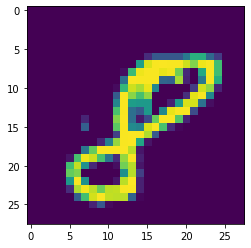

In [16]:
import matplotlib.pyplot as plt
data, target = next(iter(tr[1]))
plt.imshow(data[0, 0, ])
print(target[0])

In [21]:
len(tr[1])

469